In [1]:
using Pkg: @pkg_str
pkg"activate ."

In [2]:
using Random
using Plots
using MLDataUtils
using Flux
using Statistics
using TensorFlow

┌ Info: Recompiling stale cache file /Users/oxinabox/.julia/compiled/v1.1/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/oxinabox/.julia/compiled/v1.1/MLDataUtils/CQWB9.ji for MLDataUtils [cc2ba9b6-d476-5e6d-8eaf-a92d5412d41d]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/oxinabox/.julia/compiled/v1.1/Flux/QdkVy.ji for Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1184


loaded


┌ Info: Recompiling stale cache file /Users/oxinabox/.julia/compiled/v1.1/TensorFlow/IhIhf.ji for TensorFlow [1d978283-2c37-5f34-9a8e-e9c0ece82495]
└ @ Base loading.jl:1184
┌ Warning: Loading a new version of TensorFlow.jl for the first time. This initial load can take around 5 minutes as code is precompiled; subsequent usage will only take a few seconds.
└ @ TensorFlow ~/Documents/oxinabox.github.io/_drafts/JuliaDeepLearningMeetupLondon2019/dev/TensorFlow/src/TensorFlow.jl:3


# Sinusoid Task: Position, Ampliude, and Frequency Detection

In [3]:
function generate_basic_paf_datum()
    p = 5randn()
    a = 7randn()
    f = randn()
    
    x= -2:0.01:2
    input =  @. a*sin(2π*f*x) + p
    output = [p, a, f]
    return (input, output)
end

generate_basic_paf_datum (generic function with 1 method)

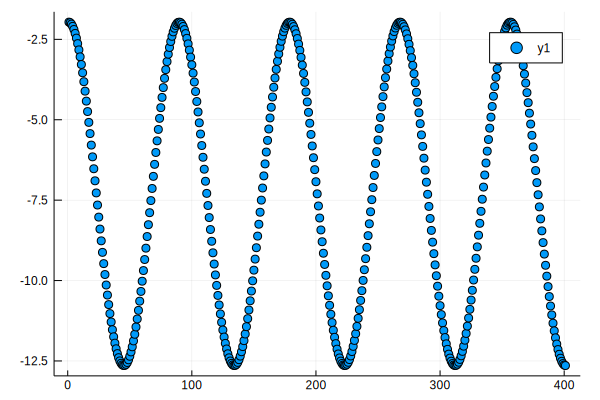

In [4]:
scatter(generate_basic_paf_datum()[1])

### MLDatasets Feature: `splitobs`
For breaking up into test, dev and training sets etc.

In [5]:
const basic_paf_raw = [generate_basic_paf_datum() for _ in 1:2000];
const basic_paf_full = mapreduce.((first,last), hcat, Ref(basic_paf_raw)) # Make dense, not require but gives speed

const basic_paf_train, basic_paf_dev, basic_paf_test = splitobs(basic_paf_full, at=(0.7, 0.1));
size.(basic_paf_train)

((401, 1400), (3, 1400))

# Model  Definition

In [6]:
function make_tf_basic_paf(in_size = 401)
    sess = Session(Graph())
    @tf begin
        x = placeholder(Float32, shape=[missing, in_size])

        W1 = get_variable((in_size, 128), Float32)
        b1 = get_variable(128, Float32)
        z1 = nn.relu(x*W1 + b1)


        W2 = get_variable((128, 128), Float32)
        b2 = get_variable(128, Float32)
        z2 = nn.relu(z1*W2 + b1)

        W3 = get_variable((128, 3), Float32)
        b3 = get_variable(2, Float32)

        y = placeholder(Float32, shape=[missing, 3])
        yp = identity([z2*W3[:, 1:2] + b3 tanh.(z2*W3[:, 3:3])])


        net_loss = reduce_mean((y .- yp).^2)
        opt = train.minimize(train.AdamOptimizer(), net_loss)
    end
    run(sess, global_variables_initializer())
    
    return (sess=sess, opt=opt)
end

make_tf_basic_paf (generic function with 2 methods)

In [7]:
function make_flux_basic_paf(in_size = 401)
    W = param(0.01randn(3, 512))
    b = param(0.01randn(2))

    return Chain(
        Dense(in_size, 512, relu), 
        Dense(512, 512, relu), 
        z->[W[1:2,:]z .+ b; tanh.(W[3:3,:]z)]
    )
end

make_flux_basic_paf (generic function with 2 methods)

## Model Use 

In [28]:
@time let 
    sess, _ = make_tf_basic_paf()
    t1, o1 = basic_paf_train |> eachobs |> first
    
    run(sess, sess.graph["yp"], Dict(sess.graph["x"]=>t1'))'
end

  1.551888 seconds (3.04 M allocations: 164.251 MiB, 4.05% gc time)


3×1 LinearAlgebra.Adjoint{Float32,Array{Float32,2}}:
  0.0076559796
 -0.009105545 
  0.0028432817

In [29]:
@time let 
    model = make_flux_basic_paf()
    t1, o1 = basic_paf_train |> eachobs |> first
    model(t1)
end

  0.016575 seconds (403 allocations: 7.244 MiB, 69.66% gc time)


Tracked 3-element Array{Float64,1}:
 -0.44306867302224756
 -0.8375240804752252 
  0.06273689158583064

## Model Training

In [10]:
function train_tf(model, train_data, dev_data, test_data)
    sess, opt = model
    
    train_x, train_y = permutedims.(train_data)
    dev_x, dev_y = permutedims.(dev_data)
    test_x, test_y = permutedims.(test_data)
    
    ######

    loss_dev = run(sess, sess.graph["net_loss"], Dict(sess.graph["x"]=>dev_x, sess.graph["y"]=>dev_y))
    @show loss_dev
    
    prev_loss_dev = loss_dev
    for epoch in 1:10
        for (batch_x, batch_y) in eachbatch((train_x, train_y), 1000, ObsDim.First())
            run(sess, opt, Dict(sess.graph["x"]=>train_x, sess.graph["y"]=>train_y))
        end
    
        loss_dev = run(sess, sess.graph["net_loss"], Dict(sess.graph["x"]=>dev_x, sess.graph["y"]=>dev_y))
        @show loss_dev
        if loss_dev > prev_loss_dev
            break # early stopping
        end
        prev_loss_dev = loss_dev
    end
    
    test_loss = run(sess, sess.graph["net_loss"], Dict(sess.graph["x"]=>test_x, sess.graph["y"]=>test_y))
    @show test_loss
    return model
end

train_tf (generic function with 1 method)

In [26]:
function train_flux(model, train_data, dev_data, test_data)
    loss_((x,y))=loss_(x,y)
    function loss_(x, y)
        ŷ = model(x)
        mean((ŷ .- y).^2)
    end

    opt = ADAM()
    ps = params(model)
    
        
    loss_dev = loss_(dev_data)
    @show loss_dev
    
    prev_loss_dev = loss_dev
    for epoch in 1:10
        Flux.train!(
            loss_,
            ps,
            eachbatch(train_data, 1000),
            opt
        )
        
        loss_dev = loss_(dev_data)
        @show loss_dev
        if loss_dev > prev_loss_dev
            break # early stopping
        end
        prev_loss_dev = loss_dev
    end
    
    loss_test = loss_(test_data)
    @show loss_test
    return model
end

GC.gc()
@time train_flux(make_flux_basic_paf(), basic_paf_train, basic_paf_dev, basic_paf_test);

loss_dev = 27.70192471775397 (tracked)
loss_dev = 20.102257897507116 (tracked)
loss_dev = 22.91664002907136 (tracked)
loss_test = 17.97384303577596 (tracked)
  0.121170 seconds (65.86 k allocations: 98.344 MiB, 13.61% gc time)


## Training time

In [27]:
GC.gc() 
@time train_tf(make_tf_basic_paf(), basic_paf_train, basic_paf_dev, basic_paf_test);

loss_dev = 27.692549f0
loss_dev = 27.502308f0
loss_dev = 27.063148f0
loss_dev = 26.328619f0
loss_dev = 25.249126f0
loss_dev = 23.824215f0
loss_dev = 22.17491f0
loss_dev = 20.592035f0
loss_dev = 19.55188f0
loss_dev = 19.708519f0
test_loss = 15.580833f0
  1.745752 seconds (3.06 M allocations: 245.275 MiB, 4.58% gc time)


# Under Noise

In [13]:
function generate_noisy_paf_datum()
    p = 5randn()
    a = 7randn()
    f = randn()
    
    x= -2:0.01:2
    np = [0.1*randn() for _ in x]
    na = [0.1*randn() for _ in x]
    nf = [0.005*randn() for _ in x]

    
    input =  @. a*sin(2π*(f+nf)*x + np) + p + na
    output = [p, a, f]
    return (input, output)
end

generate_noisy_paf_datum (generic function with 1 method)

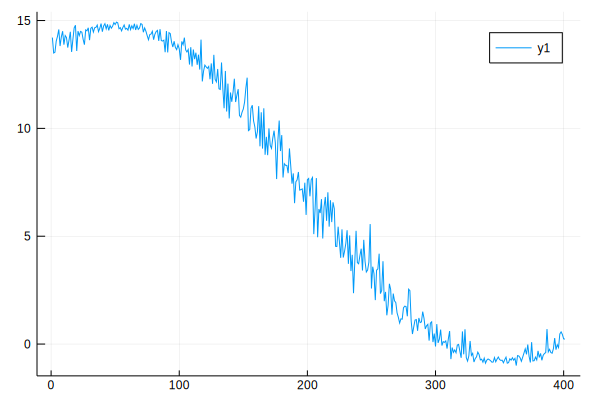

In [14]:
x, y = generate_noisy_paf_datum()
plot(x)

In [15]:
const noisy_paf_raw = [generate_noisy_paf_datum() for _ in 1:2000];
const noisy_paf_full = mapreduce.((first,last), hcat, Ref(noisy_paf_raw)) # Make dense, not require but gives speed

const noisy_paf_train, noisy_paf_dev, noisy_paf_test = splitobs(noisy_paf_full, at=(0.7, 0.1));
@show typeof(noisy_paf_train[1])
@show typeof(noisy_paf_train[2])

typeof(noisy_paf_train[1]) = SubArray{Float64,2,Array{Float64,2},Tuple{Base.Slice{Base.OneTo{Int64}},UnitRange{Int64}},true}
typeof(noisy_paf_train[2]) = SubArray{Float64,2,Array{Float64,2},Tuple{Base.Slice{Base.OneTo{Int64}},UnitRange{Int64}},true}


SubArray{Float64,2,Array{Float64,2},Tuple{Base.Slice{Base.OneTo{Int64}},UnitRange{Int64}},true}

In [24]:
GC.gc()
@time train_flux(make_flux_basic_paf(), noisy_paf_train, noisy_paf_dev, noisy_paf_test);

loss_dev = 26.635220901789715 (tracked)
loss_dev = 18.136506776297608 (tracked)
loss_dev = 18.96510142261529 (tracked)
loss_test = 20.22306429695667 (tracked)
  0.087949 seconds (2.98 k allocations: 95.133 MiB, 19.09% gc time)


In [25]:
GC.gc()
@time train_tf(make_tf_basic_paf(), noisy_paf_train, noisy_paf_dev, noisy_paf_test);

loss_dev = 26.054228f0
loss_dev = 25.747723f0
loss_dev = 25.178738f0
loss_dev = 24.270609f0
loss_dev = 22.970459f0
loss_dev = 21.33249f0
loss_dev = 19.637566f0
loss_dev = 18.349474f0
loss_dev = 18.134903f0
loss_dev = 18.648956f0
test_loss = 18.989697f0
  1.756562 seconds (3.06 M allocations: 245.166 MiB, 4.72% gc time)


# NonStationary

In [30]:
function generate_ns_paf_datum(t)
    p = 5randn()
    a = 7randn()
    f = randn()
    
    x= -2:0.01:2
    np = 4(t-0.5)^2
    nf = 0.1t
     
    input =  @. a*sin(2π*(f+nf)*x) + p + np
    output = [p, a, f]
    return (input, output)
end

generate_ns_paf_datum (generic function with 1 method)

In [31]:
const ns_paf_raw = [generate_ns_paf_datum(ii/200_000) for ii in 1:20_000];
const ns_paf_full = mapreduce.((first,last), hcat, Ref(ns_paf_raw)) # Make dense, not require but gives speed

const ns_paf_train, ns_paf_dev, ns_paf_test = splitobs(ns_paf_full, at=(0.7, 0.1));

In [32]:
GC.gc()
@time train_flux(make_flux_basic_paf(), ns_paf_train, ns_paf_dev, ns_paf_test);

loss_dev = 24.399785967523396 (tracked)
loss_dev = 17.369080337486505 (tracked)
loss_dev = 16.856124447448437 (tracked)
loss_dev = 16.768279376824186 (tracked)
loss_dev = 16.752346175449137 (tracked)
loss_dev = 16.767412356919618 (tracked)
loss_test = 16.78348323061751 (tracked)
  3.842632 seconds (73.31 k allocations: 2.640 GiB, 23.52% gc time)


In [33]:
GC.gc() 
@time train_tf(make_tf_basic_paf(), ns_paf_train, ns_paf_dev, ns_paf_test);

loss_dev = 25.104187f0
loss_dev = 16.704453f0
loss_dev = 16.774794f0
test_loss = 16.77865f0
  4.147163 seconds (3.06 M allocations: 1.438 GiB, 8.85% gc time)
